Let us look at how we can implement text classification with Tensorflow https://www.tensorflow.org/
TensorFlow is an end-to-end open source platform for machine learning. 
The dataset is from the Tweet Sentiment Extraction challenge from Kaggle(https://www.kaggle.com/c/tweet-sentiment-extraction/overview)
We would implement text classification using a simple convolutional network developed using Tensorflow on tweet data to classify tweets as "positive","negative" or "neutral"

In [ ]:
!git clone https://github.com/mdt01/Tweet_Dataset_NLP.git

Cloning into 'Tweet_Dataset_NLP'...
remote: Enumerating objects: 4, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 4 (delta 0), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (4/4), 1.36 MiB | 2.25 MiB/s, done.


In [ ]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf
from tensorflow.keras import regularizers

from tensorflow.keras import layers
from tensorflow.keras import losses

from collections import Counter

import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from tensorflow.keras import preprocessing
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import pydot

Let us define methods to pre-process the tweets

In [ ]:
def text_clean(corpus):
    '''
    Purpose : Function to keep only alphabets, digits and certain words (punctuations, qmarks, tabs etc. removed)
    
    Input : Takes a text corpus, 'corpus' to be cleaned along with a list of words, 'keep_list', which have to be retained
            even after the cleaning process
    
    Output : Returns the cleaned text corpus
    
    '''
    # cleaned_corpus = pd.Series()
    # for row in corpus:
    qs = []
    for word in corpus.split():
        
        p1 = re.sub(pattern='[^a-zA-Z0-9]',repl=' ',string=word)
        p1 = p1.lower()
        qs.append(p1)
   
    return ' '.join(qs)

In [ ]:
train_data= pd.read_csv("/content/Tweet_Dataset_NLP/train.csv")
train_data.dropna(axis = 0, how ='any',inplace=True) 
train_data['Num_words_text'] = train_data['text'].apply(lambda x:len(str(x).split())) 
mask = train_data['Num_words_text'] >2
train_data = train_data[mask]
print('-------Train data--------')
print(train_data['sentiment'].value_counts())
print(len(train_data))
print('-------------------------')
max_train_sentence_length  = train_data['Num_words_text'].max()


train_data['text'] = train_data['text'].apply(text_clean)


test_data= pd.read_csv("/content/Tweet_Dataset_NLP/test.csv")
test_data.dropna(axis = 0, how ='any',inplace=True) 
test_data['Num_words_text'] = test_data['text'].apply(lambda x:len(str(x).split())) 

max_test_sentence_length  = test_data['Num_words_text'].max()

mask = test_data['Num_words_text'] >2
test_data = test_data[mask]

print('-------Test data--------')
print(test_data['sentiment'].value_counts())
print(len(test_data))
print('-------------------------')

test_data['text'] = test_data['text'].apply(text_clean)



print('Train Max Sentence Length :'+str(max_train_sentence_length))
print('Test Max Sentence Length :'+str(max_test_sentence_length))

#all_sentences = train_data['text'].tolist() + test_data['text'].tolist()


-------Train data--------
neutral     10704
positive     8375
negative     7673
Name: sentiment, dtype: int64
26752
-------------------------
-------Test data--------
neutral     1376
positive    1075
negative     983
Name: sentiment, dtype: int64
3434
-------------------------
Train Max Sentence Length :33
Test Max Sentence Length :32


Let us split the training data into train and validation datasets
Let us convert our training,validation and test data into the format accepted by tensorflow

***
https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer
<br>
This class allows to vectorize a text corpus, by turning each text into either a sequence of integers (each integer being the index of a token in a dictionary) or into a vector where the coefficient for each token could be binary, based on word count, based on tf-idf...
***

oov_token = out of vocabulary

In [ ]:
num_words = 20000

tokenizer = Tokenizer(num_words=num_words,oov_token="unk")
tokenizer.fit_on_texts(train_data['text'].tolist())

print(str(tokenizer.texts_to_sequences(['xyz how are you'])))

[[1, 80, 39, 8]]


Some classification problems do not have a balanced number of examples for each class label. As such, it is desirable to split the dataset into train and test sets in a way that preserves the same proportions of examples in each class as observed in the original dataset.

This is called a stratified train-test split.

We can achieve this by setting the “stratify” argument to the y component of the original dataset. This will be used by the train_test_split() function to ensure that both the train and test sets have the proportion of examples in each class that is present in the provided “y” array.

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(train_data['text'].tolist(),\
                                                      train_data['sentiment'].tolist(),\
                                                      test_size=0.1,\
                                                      stratify = train_data['sentiment'].tolist(),\
                                                      random_state=0)


print('Train data len:'+str(len(X_train)))
print('Class distribution'+str(Counter(y_train)))
print('Valid data len:'+str(len(X_valid)))
print('Class distribution'+ str(Counter(y_valid)))


x_train = np.array( tokenizer.texts_to_sequences(X_train) )
x_valid = np.array( tokenizer.texts_to_sequences(X_valid) )
x_test  = np.array( tokenizer.texts_to_sequences(test_data['text'].tolist()) )



x_train = pad_sequences(x_train, padding='post', maxlen=40)
x_valid = pad_sequences(x_valid, padding='post', maxlen=40)
x_test = pad_sequences(x_test, padding='post', maxlen=40)

print(x_train[0])

le = LabelEncoder()

train_labels = le.fit_transform(y_train)
train_labels = np.asarray( tf.keras.utils.to_categorical(train_labels))
#print(train_labels)
valid_labels = le.transform(y_valid)
valid_labels = np.asarray( tf.keras.utils.to_categorical(valid_labels))

test_labels = le.transform(test_data['sentiment'].tolist())
test_labels = np.asarray(tf.keras.utils.to_categorical(test_labels))
list(le.classes_)


train_ds = tf.data.Dataset.from_tensor_slices((x_train,train_labels))
valid_ds = tf.data.Dataset.from_tensor_slices((x_valid,valid_labels))
test_ds = tf.data.Dataset.from_tensor_slices((x_test,test_labels))


Train data len:24076
Class distributionCounter({'neutral': 9633, 'positive': 7537, 'negative': 6906})
Valid data len:2676
Class distributionCounter({'neutral': 1071, 'positive': 838, 'negative': 767})


<ipython-input-6-1f651ba4dc1f>:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x_train = np.array( tokenizer.texts_to_sequences(X_train) )
<ipython-input-6-1f651ba4dc1f>:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x_valid = np.array( tokenizer.texts_to_sequences(X_valid) )
<ipython-input-6-1f651ba4dc1f>:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' 

[  65   14    8   23   45    4    1   11   43  927  203    1  208    1
 9384 1574 6784    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0]


In [ ]:
print(y_train[:10])
train_labels = le.fit_transform(y_train)
print('Text to number')
print(train_labels[:10])
train_labels = np.asarray( tf.keras.utils.to_categorical(train_labels))
print('Number to category')
print(train_labels[:10])

['positive', 'positive', 'neutral', 'negative', 'neutral', 'negative', 'positive', 'positive', 'positive', 'neutral']
Text to number
[2 2 1 0 1 0 2 2 2 1]
Number to category
[[0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]]


In [ ]:
count =0
print('======Train dataset ====')
for value,label in train_ds:
    count += 1
    print(value,label)
    if count==3:
        break
count =0
print('======Validation dataset ====')
for value,label in valid_ds:
    count += 1
    print(value,label)
    if count==3:
        break
print('======Test dataset ====')
for value,label in test_ds:
    count += 1
    print(value,label)
    if count==3:
        break  

Streaming output truncated to the last 5000 lines.
[  925 15833    68     1    98  1835    36    46    28    34   368    50
     5  3997    11    43  6223    52     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0], shape=(40,), dtype=int32) tf.Tensor([1. 0. 0.], shape=(3,), dtype=float32)
tf.Tensor(
[ 52 251  16  13  34 102   2  84  32  14 361   7  13 129  13  24   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0], shape=(40,), dtype=int32) tf.Tensor([0. 0. 1.], shape=(3,), dtype=float32)
tf.Tensor(
[  23  275   36    7   29    5  382  215 1533  126    5  408  507    5
    1 1542  731   16 2930  429  119    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0], shape=(40,), dtype=int32) tf.Tensor([0. 1. 0.], shape=(3,), dtype=float32)
tf.Tensor(
[  63   20    3    7   13  115 1293    4  686    9   30   23 5739 1291
    

Let us create a simple Convolutional Neural Network model  
<br>
<br>
Keras is a high-level API that's easier for ML beginners, as well as researchers.
It is integrated as part of Tensorflow 2.0
<br>
I am using the Sequential model
A Sequential model is appropriate for a plain stack of layers where each layer has exactly one input tensor and one output tensor.
Source :https://www.tensorflow.org/guide/keras/sequential_model
***

In [ ]:
max_features =20000
embedding_dim =64
sequence_length = 40

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(max_features +1, embedding_dim, input_length=sequence_length,\
                                    embeddings_regularizer = regularizers.l2(0.0005)))                                    

model.add(tf.keras.layers.Conv1D(128,3, activation='relu',\
                                 kernel_regularizer = regularizers.l2(0.0005),\
                                 bias_regularizer = regularizers.l2(0.0005)))                               


model.add(tf.keras.layers.GlobalMaxPooling1D())

model.add(tf.keras.layers.Dropout(0.5))

model.add(tf.keras.layers.Dense(3, activation='sigmoid',\
                                kernel_regularizer=regularizers.l2(0.001),\
                                bias_regularizer=regularizers.l2(0.001),))
                               



model.summary()
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), optimizer='Nadam', metrics=["CategoricalAccuracy"])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 40, 64)            1280064   
                                                                 
 conv1d (Conv1D)             (None, 38, 128)           24704     
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 3)                 387       
                                                                 
Total params: 1,305,155
Trainable params: 1,305,155
Non-trainable params: 0
______________________________________________

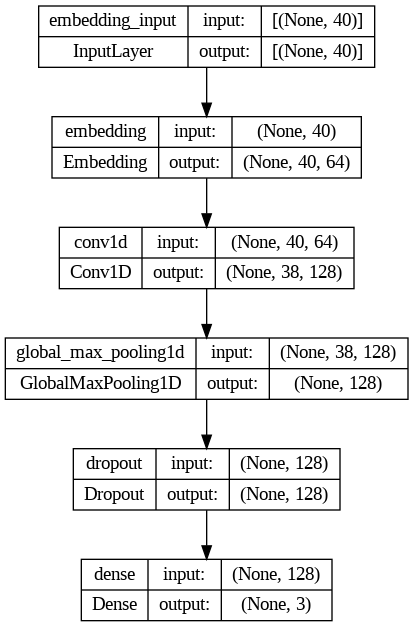

In [ ]:
tf.keras.utils.plot_model(model, "multi_input_and_output_model.png", show_shapes=True)

Let's train our model

In [ ]:
epochs = 100
# Fit the model using the train and test datasets.
#history = model.fit(x_train, train_labels,validation_data= (x_test,test_labels),epochs=epochs )
history = model.fit(train_ds.shuffle(2000).batch(128),
                    epochs= epochs ,
                    validation_data=valid_ds.batch(128),
                    verbose=1)

Epoch 1/100


/usr/local/lib/python3.8/dist-packages/keras/backend.py:5534: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


189/189 [==============================] - 14s 64ms/step - loss: 1.0655 - categorical_accuracy: 0.5331 - val_loss: 0.8126 - val_categorical_accuracy: 0.6857
Epoch 2/100
189/189 [==============================] - 12s 61ms/step - loss: 0.7989 - categorical_accuracy: 0.7042 - val_loss: 0.7681 - val_categorical_accuracy: 0.7246
Epoch 3/100
189/189 [==============================] - 12s 61ms/step - loss: 0.7584 - categorical_accuracy: 0.7269 - val_loss: 0.7690 - val_categorical_accuracy: 0.7280
Epoch 4/100
189/189 [==============================] - 12s 64ms/step - loss: 0.7407 - categorical_accuracy: 0.7408 - val_loss: 0.7783 - val_categorical_accuracy: 0.7287
Epoch 5/100
189/189 [==============================] - 12s 65ms/step - loss: 0.7228 - categorical_accuracy: 0.7561 - val_loss: 0.7903 - val_categorical_accuracy: 0.7347
Epoch 6/100
154/189 [=======================>......] - ETA: 2s - loss: 0.7114 - categorical_accuracy: 0.7660

KeyboardInterrupt: ignored

In [ ]:
history.history


{'loss': [1.0584529638290405,
  0.7945717573165894,
  0.7554441690444946,
  0.7354046702384949,
  0.7160965204238892,
  0.7028456926345825,
  0.6912397146224976,
  0.6791294813156128,
  0.6650612354278564,
  0.6588897705078125,
  0.6477208733558655,
  0.6378365159034729,
  0.6308867335319519,
  0.6181772947311401,
  0.6166952252388,
  0.6120909452438354,
  0.599109947681427,
  0.5928993821144104,
  0.5899579524993896,
  0.5828645825386047,
  0.578955352306366,
  0.5758377909660339,
  0.569199800491333,
  0.5660958886146545,
  0.5599343776702881,
  0.560337483882904,
  0.5553449392318726,
  0.5500941872596741,
  0.5493625402450562,
  0.5466230511665344,
  0.5397339463233948,
  0.5409982800483704,
  0.542426347732544,
  0.5376569032669067,
  0.532310426235199,
  0.5337250828742981,
  0.5337944626808167,
  0.5303115248680115,
  0.5288476347923279,
  0.5267488956451416,
  0.5266357660293579,
  0.5261639952659607,
  0.5231339931488037,
  0.5173501968383789,
  0.5175022482872009,
  0.5178871

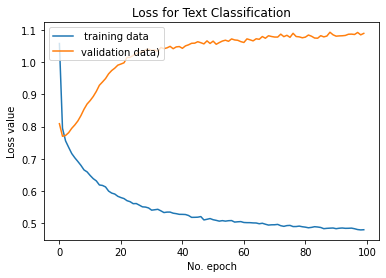

In [ ]:

plt.plot(history.history['loss'], label=' training data')
plt.plot(history.history['val_loss'], label='validation data)')
plt.title('Loss for Text Classification')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

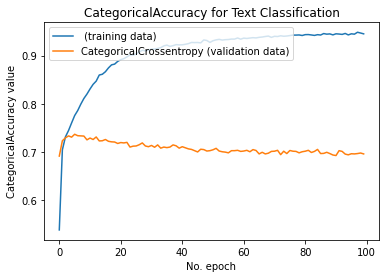

In [ ]:


plt.plot(history.history['categorical_accuracy'], label=' (training data)')
plt.plot(history.history['val_categorical_accuracy'], label='CategoricalCrossentropy (validation data)')
plt.title('CategoricalAccuracy for Text Classification')
plt.ylabel('CategoricalAccuracy value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()


In [ ]:

# Generate predictions (probabilities -- the output of the last layer)
# on test  data using `predict`
print("Generate predictions for all samples")
predictions = model.predict(x_test)
print(predictions)
predict_results = predictions.argmax(axis=1)


Generate predictions for all samples
108/108 [==============================] - 0s 2ms/step
[[3.5357758e-01 8.0854070e-01 2.9395112e-01]
 [5.2434109e-02 6.9393909e-01 8.8481301e-01]
 [9.7981703e-01 6.2922055e-01 1.1648218e-02]
 ...
 [8.3516669e-01 2.1154420e-01 4.1506279e-01]
 [7.6478894e-04 9.4696122e-01 9.8594743e-01]
 [1.2721972e-03 7.4017811e-01 9.9624586e-01]]


In [ ]:
test_data['pred_sentiment']= predict_results
test_data['pred_sentiment'] = np.where((test_data.pred_sentiment == '0'),'negative',test_data.pred_sentiment)
test_data['pred_sentiment'] = np.where((test_data.pred_sentiment == '1'),'neutral',test_data.pred_sentiment)
test_data['pred_sentiment'] = np.where((test_data.pred_sentiment == '2'),'positive',test_data.pred_sentiment)

In [ ]:
labels = ['positive', 'negative','neutral']
    
print(classification_report(test_data['sentiment'].tolist(),test_data['pred_sentiment'].tolist(),labels=labels))

              precision    recall  f1-score   support

    positive       0.76      0.75      0.75      1075
    negative       0.00      0.00      0.00       983
     neutral       0.64      0.66      0.65      1376

   micro avg       0.69      0.50      0.58      3434
   macro avg       0.47      0.47      0.47      3434
weighted avg       0.49      0.50      0.50      3434



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
